# Polynomial approximations for correlated variables

In [53]:
from equadratures import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In this post, we introduce a new heuristic in EQ for forming polynomial approximations with input variables that are correlated, the Gram-Schmidt method. In addition, a new method for non-tensorial quadrature---Leja sequences---is also introduced. Our implementation and exposition is based on the proposal by Jakeman et al. [1], where more theoretical details can be found.


In EQ, polynomial approximations are formed by linear combinations of multivariate orthogonal basis polynomials,

$$
f(\mathbf{x}) \approx \sum_{i=1}^P a_i \Phi_i(\mathbf{x}).
$$

 When the input variables are independent from each other, the distribution over the input variables is the product of the marginal distributions,

  $$
\omega(\mathbf{s}) = \prod_{j=1}^d \omega_j (x_j) .
 $$

 For each dimension, a basis of _univariate_ basis polynomials can be found such that

 $$
\int \phi^{j}_a (x_j) \; \phi^{j}_b (x_j) \; \omega_j(x_j) \; \text{d}x_j = \delta_{ab}
 $$

i.e. they are orthogonal. The multivariate basis can then be formed from the tensor product of univariate bases. That is, each multivariate basis polynomial can be written as

$$
\Phi_i(\mathbf{x}) = \phi^1_{i1} (x_1) \; \phi^2_{i2} (x_2) \; ... \; \phi^d_{id} (x_d).
$$

However, this is not possible when the variables are correlated with each other. An orthogonal basis needs to be constructed in another way. One method is to transform the input variables via the Nataf transform. In this method, we seek the invertible link transformation $T$ between the input variables ($\mathbf{x}$) and a set of uncorrelated standard normally distributed variables ($\mathbf{z}$), 

$$
\mathbf{z} = T(\mathbf{x})
$$

Thus, the function to be approximated can be expressed in terms of uncorrelated normal variables, for which an orthogonal polynomial basis can be constructed,

$$
f(\mathbf{x}) = f(T^{-1}(\mathbf{z})) \approx \sum_{i=1}^P a_i \Phi_i(\mathbf{z}).
$$

Assuming that the correlation between variables are linear, solving for the transformation amounts to numerically a set of non-linear equations, which can be solved efficiently via root-finding algorithms. The main challenge with this method is the process of fitting a polynomial to the composite function $f \circ T^{-1}$. Including the inverse transform $T^{-1}$ often introduces strong non-linearities that are difficult to fit using a polynomial. 

Another approach presented in Jakeman et al. uses the Gram-Schmidt process to form an orthogonal polynomial basis. First, we can ignore the correlations between inputs and construct an orthogonal basis by the tensor product of orthogonal bases for the respective marginal distributions. The basis $(\psi)$ is then a linearly independent set of polynomials, but they are not orthogonal to the input measure since the correlations are not accounted for. The Gram Schmidt (GS) process is then applied to this set of polynomials to form an orthogonal set with the same span $(\phi)$. When applying GS to finite dimensional vectors, at each step we subtract the projection of the current vector to the subspace spanned by all previous vectors from the current vector. This involves taking inner products with the vectors in previous iterations, which is the commonly known dot product. For polynomials, the inner product is defined by integrating the two polynomials weighted by the measure,

$$
\langle \phi, \psi\rangle = \int \phi (\mathbf{x}) \; \psi (\mathbf{x}) \; \omega(\mathbf{x}) \; \text{d}\mathbf{x},
$$

which calls for a _quadrature method_ for the input measure $\omega$. A simple heuristic is to use Monte Carlo---by drawing samples from $\omega$. This can be done by transforming samples from the standard normal distribution with the Nataf transform, as described above. 

With samples from $\omega$, the GS process can be performed efficiently with QR decomposition,

$$
\sqrt{\mathbf{W}} \mathbf{\Psi} = \mathbf{Q} \mathbf{R},
$$

where $\mathbf{W} = \text{diag}(1/N, 1/N, ..., 1/N)$ where $N$ is the number of samples drawn, and $\mathbf{\Psi}$ is the Vandermonde matrix, $\mathbf{\Psi}_{ij} = \psi_j(\mathbf{x}_i)$. Here, $\psi_j$ is the $j$-th basis polynomial of the uncorrelated basis and $\mathbf{x}_i$ the $i$-th sample from a pool drawn according to $\omega$. The upper triangular matrix $\mathbf{R}$ is invertible (because the basis ($\psi$) is linearly independent), and can be used to construct the new orthogonal basis

$$
\phi_j (\mathbf{x}) = \sum_{k=1}^j \psi_k(\mathbf{x}) \;(\mathbf{R}^{-1})_{kj}.
$$

Since there is a sign ambiguity in QR factorisations, a small detail that needs to be enforced is that the top left entry of $\mathbf{R}$ should be positive (unity if the polynomials are already normalised). This ensures that the output mean of the transformed polynomial has the correct sign.

## Leja sequences

Once the basis is established, the approximation problem can be solved by coefficient computation strategies. In EQ, this can be numerical integration on a tensor grid, least squares, compressed sensing etc. In the present case, the input measure is not amenable to Gaussian quadrature (in fact, using `numerical-integration` in this case is not recommended, because the quadrature points correspond to the uncorrelated measure and are no longer optimal), so we opt for a method based on random sampling. That is, we aim to get an approximation

$$
\mathbf{\Phi} \mathbf{a} \approx \mathbf{y}
$$

 The goal is to improve the conditioning of the Vandermonde matrix $\mathbf{\Phi}$ by choosing a suitable sampling scheme. For example,  there has been substantial work on formulating tailored distributions to maximise the determinant of the Vandermonde matrix (called induced distributions). Another orthogonal approach is to prune down a pool of samples (prior to evaluating the function on these points) via subsampling methods, such as QR column pivoting and LU row pivoting. We focus on subsampling via LU row pivoting, also called Leja sequences. The procedure is summarised as follows:

 1. Sample $N'$ points from the distribution $\omega$, where $N$ should be much larger than the number of basis terms $P$.
 2. Evaluate the Vandermonde matrix on these points to get $\mathbf{\Phi}' \in \mathbb{R}^{N' \times P}$.
 3. Perform partially pivoted LU factorisation, such that $\mathbf{P} \mathbf{V} \mathbf{\Phi}' = \mathbf{L} \mathbf{U}$, where $\mathbf{V}$ is a preconditioning matrix, e.g. a diagonal matrix with the sqaure root of the PDF at the corresponding point.
 4. Select the rows with the largest pivots using $\mathbf{P}$ to form $\mathbf{\Phi} \in \mathbb{R}^{N \times P}$, where $N < N'$.

Usually, we select $N = P$ to minimise the number of function evaluations required.

## Implementation

The new version of ``equadratures`` introduces an update to the ```Correlations``` class, implementing the Nataf transform and Gram Schmidt methods of polynomial approximation under a unified syntax. An example of its usage is given below.


Analogous to the uncorrelated case, the first step is to define a list of parameters using ```Parameter``` objects and a basis using the ```Basis``` object. The parameters are defined with their marginal distributions. A ```Poly``` object can then be initialised. Here, we specify that the mesh is generated with Monte Carlo sampling (currently it is the only method that supports correlated sample generation), and subsampling with LU row pivoting. 

Then, the ```Correlations``` object is initialised with the correlation matrix, containing the linear correlation coefficients between different variables, and the ```Poly``` object we created just now. The method is specified as ```gram-schmidt```. After this step, the ```Correlations``` object internally creates a "transformed" version of the ```Poly``` object that accounts for the input correlations. To compute the coefficients of this transformed ```Poly```, we need to call the ```set_model()``` method within the ```Correlations``` object (Note: not the ```set_model``` method of the transformed ```Poly``` itself.). The transformed ```Poly``` object can be accessed with the ```get_transformed_poly()``` method, from which we can examine its coefficients, calculate moments and statistics etc.

Two features worth highlighting within the ```Correlations``` class are the ```get_correlated_samples()``` and ```get_pdf()``` methods. It is worth noting that for these methods, we do not need to fit a polynomial approximation. Only the correlation matrix and marginal distributions are required. Example usages are as below. Note that no method needs to be specified.

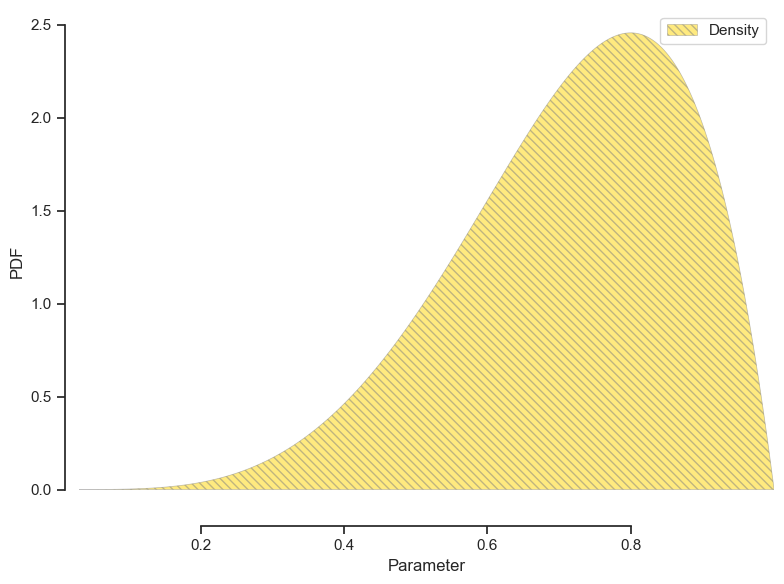

In [54]:
def func(s):
    s1 = s[0]
    s2 = s[1]
    return s1**2 - s2**3 - 2. * s1 - 0.5 * s2

parameters = [Parameter(distribution='beta', shape_parameter_A=5.0, shape_parameter_B=2.0, \
                        lower=0.0, upper=1.0, order=15) for _ in range(2)]

parameters[0].plot_pdf()

In [84]:
basis = Basis('total-order')
uncorr_poly = Poly(parameters, basis, method='least-squares',
                    sampling_args={'mesh': 'monte-carlo',
                                    'subsampling-algorithm': 'lu'})

corr_mat = np.array([[1.0, -0.855],
                    [-0.855, 1.0]])

corr_gs = Correlations(corr_mat, poly=uncorr_poly, method='gram-schmidt')
corr_gs.set_model(func)
corrected_poly_gs = corr_gs.get_transformed_poly()
print(corrected_poly_gs.get_mean_and_variance())
data_orig = corr_gs.get_correlated_samples(7000)

(-1.6776819696000072, 0.052726743169775596)


In [80]:
pts, wts = corrected_poly_gs.get_points_and_weights()

In [81]:
corr = Correlations(corr_mat, parameters=parameters)
X_test = np.random.uniform(size=(10, 2))

corr.get_pdf(X_test)
data = corr.get_correlated_samples(4000)

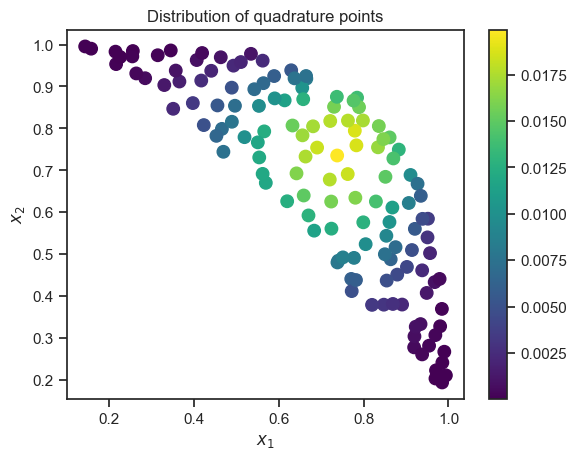

In [83]:
c = plt.scatter(pts[:,0], pts[:,1], c=wts, s=80,  cmap='viridis')
plt.colorbar()
plt.title('Distribution of quadrature points')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

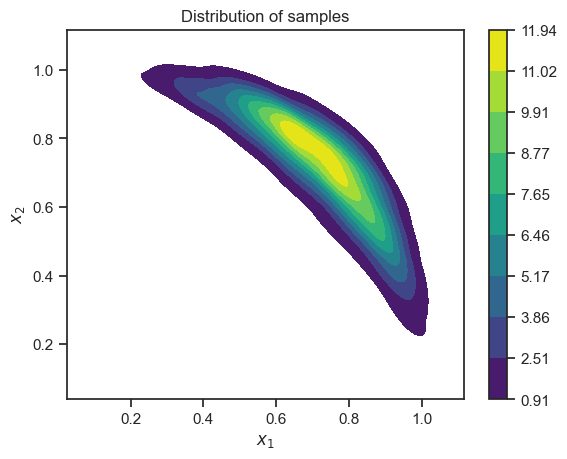

In [77]:
sns.kdeplot(x=data[:,0], y=data[:,1], color='k', fill=True, cbar=True, cmap='viridis')
plt.title('Distribution of samples')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

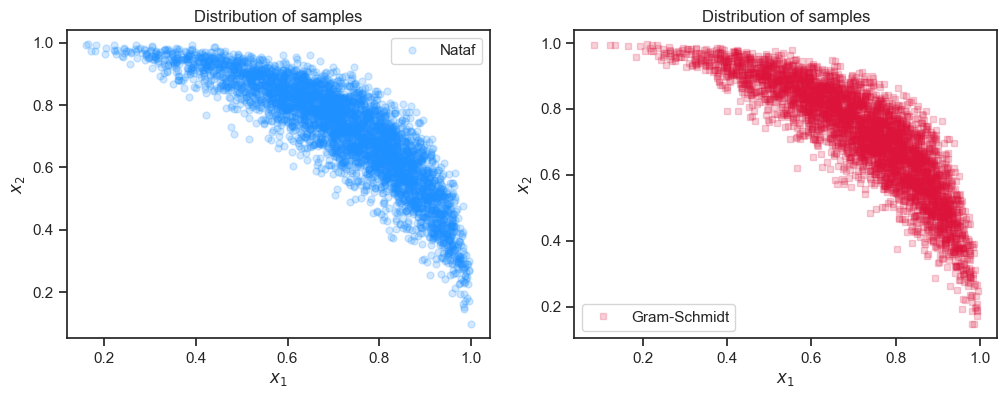

In [45]:
fig = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(data[:,0], data[:,1], 'o', alpha=0.2, ms=5, color='dodgerblue', label='Nataf')
plt.title('Distribution of samples')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.subplot(122)
plt.plot(data_orig[:,0], data_orig[:,1], 's', alpha=0.2, ms=5, color='crimson', label='Gram-Schmidt')
plt.title('Distribution of samples')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()

In [46]:
pts, wts = corrected_poly_gs.get_points_and_weights()
pts_orig, wts_orig = uncorrelated_poly.get_points_and_weights()

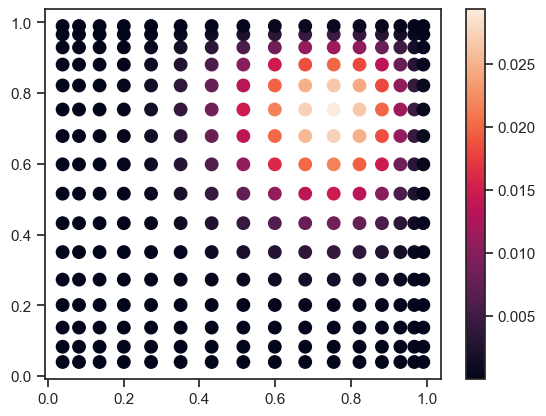

In [47]:
c = plt.scatter(pts[:,0], pts[:,1], c=wts, s=80)
plt.colorbar()
plt.show()

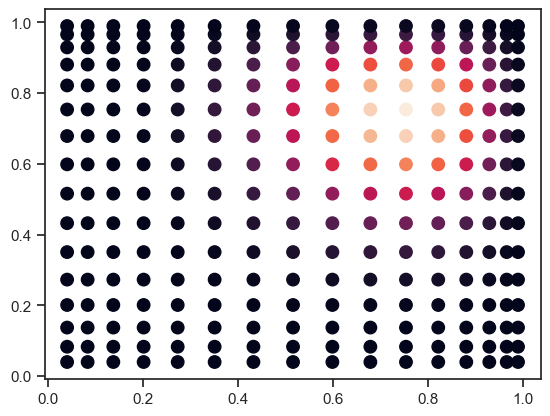

In [48]:
c = plt.scatter(pts_orig[:,0], pts_orig[:,1], c=wts_orig, s=80)

## Demonstration

Let's demonstrate the new methods on some simple use cases and compare different methods of approximating functions with correlated input variables. We will examine the approximation of an oscillatory function in 2D, defined as 

$$
f(\mathbf{x}) = \cos(2\pi b(x_1 + x_2)).
$$

for $b= 0.5, 1.5$ and $3.5$. The input variables will be distributed with beta distributions as marginal distributions, and a correlation coefficients of $\rho_{12} = -0.855$. The functions and input PDF are plotted below.

We will evaluate the quality of the approximation via two metrics: 

1. The weighted $L_2$ error, $e_w = \frac{1}{N_{test}} \left(\sum_{i=1}^{N_{test}} |f(\mathbf{x}_i) - p(\mathbf{x}_i)|^2\right)^{1/2}$, where $p$ is the polynomial approximation and $\mathbf{x}_i \sim \omega$.
2. Predictive accuracy in output mean and variance compared to a large-sample Monte Carlo estimate. 

Three methods of approximation are studied:

1. Gram-Schmidt construction of an orthogonal basis. (GS)
2. Constructing a polynomial approximation in standard Gaussian space using the Nataf transform. (NT)
3. Ignoring correlations and constructing a polynomial approximation with the marginals. (Uncorr)

In all cases, training input/output data is generated by oversampled  Monte Carlo of the correlated input density followed by subsampling using LU row pivoting on an isotropic total order basis. First, the weighted $L_2$ error is compared for the three methods for the three settings of $b$ in the Genz function, while using different maximum degrees of the polynomials. The results are shown below. 



In [ ]:
While the error using Nataf transform decreases as order increases for $b=0.5$, it fails to arrive at a reasonable approximation for any higher values---the higher the value of $b$, the stronger the non-linearity of the function. Ignoring correlations works well for low $b$, but pales in comparison with using the GS basis when more non-linearity is present, thus demanding the use of higher order polynomials. The divergence of the error may stem from the fact that the basis is not orthogonal, thus losing out on the well-conditioning guarantees normally assumed for orthogonal polynomial approximations.

Next, let's compare the estimations of the mean and variance using polynomials with Monte Carlo estimates. Using the polynomial, mean and variance is estimated by taking the leading coefficient and the sum of the remaining coefficients respectively. 

![corr_moments|690x306](upload://3ez6PmbKoKRGdE2NsrTnNV8ePUt.png) 

In this figure, blue refers to the mean and red the variance. The horizontal line is the Monte Carlo estimate with $10^5$ samples from the input measure. It can be seen that in all cases, ignoring correlations leads to incorrect estimates of the moments. For low $b$, the Nataf transform gives reasonable estimates of the moments, but fails to do so for higher $b$ due to the inabilities to fit the function itself. However, when we replace the quadrature method with Gaussian quadrature on a tensor grid in the standard normal space (NT_T)---by choosing the `numerical-integration` method, the moments are estimated with good accuracy. In all cases, the Gram-Schmidt method gives reasonable accuracy in moment estimation.

From this example, we see that the Gram-Schmidt method gives better fitting accuracy in terms of mean squared error. However, using the Nataf transform allows us to use Gaussian quadrature methods, which enhances the accuracy of moment estimation, especially for higher order moments such as skewness. 

[1]: Jakeman, J. D. et al. Polynomial chaos expansions for dependent random variables. *Comput. Methods Appl. Mech. Engrg.* 351 (2019) 643–666